# 2. Unsupervised Dimensional Reduction (PCA/SVD, ICA, and NMF)

Here, we perform some matrix factorization algorithms such as Principal Component Analysis (PCA), Independent Component Analysis (ICA), and Non-negative Matrix Factorization (NMF) for a real matrix and a real non-negative matrix.

## Setting

First, install `PyTorchDecomp`.
Here, `scikit-learn` is also installed to visualize the data by t-SNE.

In [1]:
try:
    import torchdecomp
except ImportError:
    import subprocess
    # Check Python Version (>= 3.10)
    print(subprocess.run(["python", "-V"]))
    # Install PyTorch
    repo_url = "https://github.com/chiba-ai-med/PyTorchDecomp.git"
    subprocess.check_call(f"pip install git+{repo_url}", shell=True)

try:
    import sklearn
except ImportError:
    import subprocess
    # Check Python Version (>= 3.10)
    print(subprocess.run(["python", "-V"]))
    # Install Sklearn
    subprocess.check_call("pip install scikit-learn", shell=True)

## Package Loading

Then, load the necessary packages for data analysis, including `PyTorchDecomp`.

In [2]:
import torch
import torch.nn as nn
import torchdecomp as td
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Data Download

Here, the `MNIST` (handwritten characters) data provided by `TorchVision` is used, with only 5,000 data subsampled for demonstration purposes, as follows.

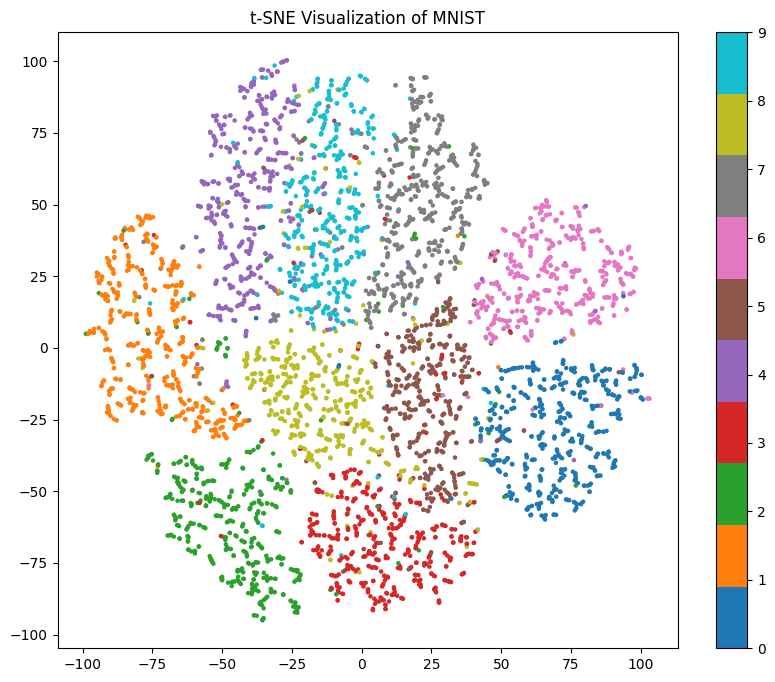

In [3]:
# Pre-processing Function
transform = transforms.ToTensor()

# Data Download
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Subsampling
torch.manual_seed(123456)
subset_indices = torch.randperm(len(mnist_dataset))[:5000]
mnist_subset = torch.utils.data.Subset(mnist_dataset, subset_indices)
all_data = torch.stack([sample[0] for sample in mnist_subset], dim=0)

# PyTorch Tensor to Numpy Array
data_np = all_data.numpy().reshape(all_data.size(0), -1)

# Numpy Array to PyTorch Tensor
data_torch = torch.tensor(data_np)

# t-SNE
torch.manual_seed(123456)
embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(data_np)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=mnist_dataset.targets[subset_indices], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

### GPU Check and Setting

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

data_torch = data_torch.to(device)

cpu


## PCA (Rec-mode)

### Normalization of data matrix

First, normalize the data matrix to set the average of column vectors zero as follows:

In [5]:
data_torch_norm = torch.nn.functional.normalize(data_torch, dim=0)

In the PCA, the normalized matrix $X$ ($n \times m$) is decomposed as follows.

$$
X = X V V^T
$$

, where $V$ is an $m \times k$ orthogonal matrix ($V^{T}V=I$).

To realize this matrix decomposition, we first prepare $V$ in `td.RecLayer`, define the loss terms (`ortho_loss_V`) to improve the orthogonality of $V$ and added to the matrix reconstruction error term in a weighted manner.

In [6]:
# Instantiation of RecLayer
torch.manual_seed(123456)
rec_layer = td.RecLayer(x=data_torch_norm, n_components=10)

# Setting Optimizer
optimizer = optim.SGD(rec_layer.parameters(), lr=2e-3)

# Weights for each objective function
weights = np.array([2, 1])
weights = weights / sum(weights)

# Iteration
loss_array = []
epochs = 100
for epoch in range(epochs):
    # Forward
    x_pred = rec_layer(data_torch_norm)
    # Loss
    ortho_loss_V = torch.norm(torch.eye(rec_layer.V.size(1)) - torch.mm(rec_layer.V.t(), rec_layer.V))
    loss = weights[0] * torch.sum((data_torch_norm - x_pred)**2) + weights[1] * ortho_loss_V
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

The calculations appear to be well converged.

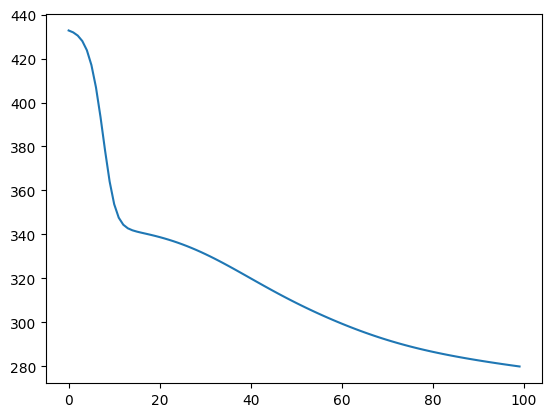

In [7]:
plt.plot(loss_array)

### Pattern Check

The scores ($XV$) seem to be able to extract patterns along with the differences in the `MNIST` numbers.

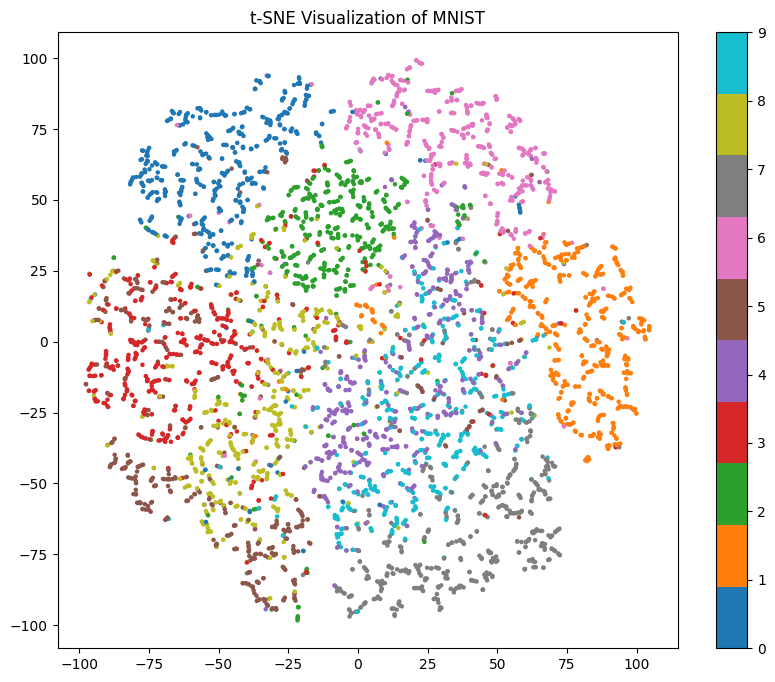

In [8]:
# t-SNE with PCA 
pca_score = data_torch.numpy() @ rec_layer.V.detach().numpy()
torch.manual_seed(123456)
pca_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(pca_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], c=mnist_dataset.targets[subset_indices], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## PCA (factor-mode × Variance)

Another formulation of PCA is to maximize the variance of the score $XV$ as follows.

$$
V = \max(\mathrm{tr}((XV)^T(XV)))
$$

In `PyTorchDecomp`, this can be expressed as an objective function in a straightforward manner; just change the reconstuction loss of PCA (Rec-mode) to `-torch.var` as follows:

In [9]:
# Instantiation of FactorLayer
torch.manual_seed(123456)
factor_layer = td.FactorLayer(x=data_torch_norm, n_components=10)

# Setting Optimizer
optimizer = optim.SGD(factor_layer.parameters(), lr=2e-7)

# Weights for each objective function
weights = np.array([20, 1])
weights = weights / sum(weights)

# Iteration
loss_array = []
epochs = 100
for epoch in range(epochs):
    # Forward
    x_pred = factor_layer(data_torch_norm)
    # Loss
    ortho_loss_V = torch.norm(torch.eye(factor_layer.V.size(1)) - torch.mm(factor_layer.V.t(), factor_layer.V))
    loss = - weights[0] * torch.var(x_pred) + weights[1] * ortho_loss_V
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

The calculations appear to be well converged.

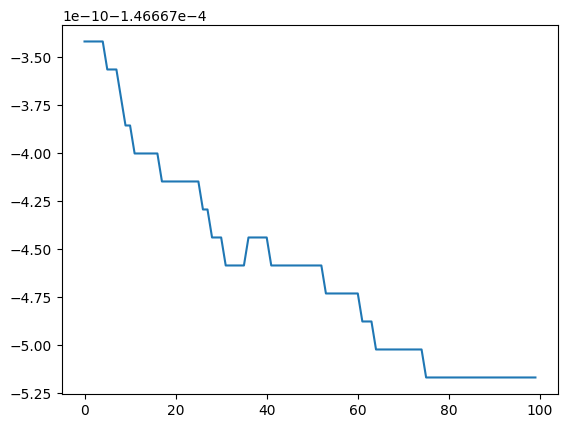

In [10]:
plt.plot(loss_array)

### Pattern Check

The scores ($XV$) seem to be able to extract patterns along with the differences in the MNIST numbers.

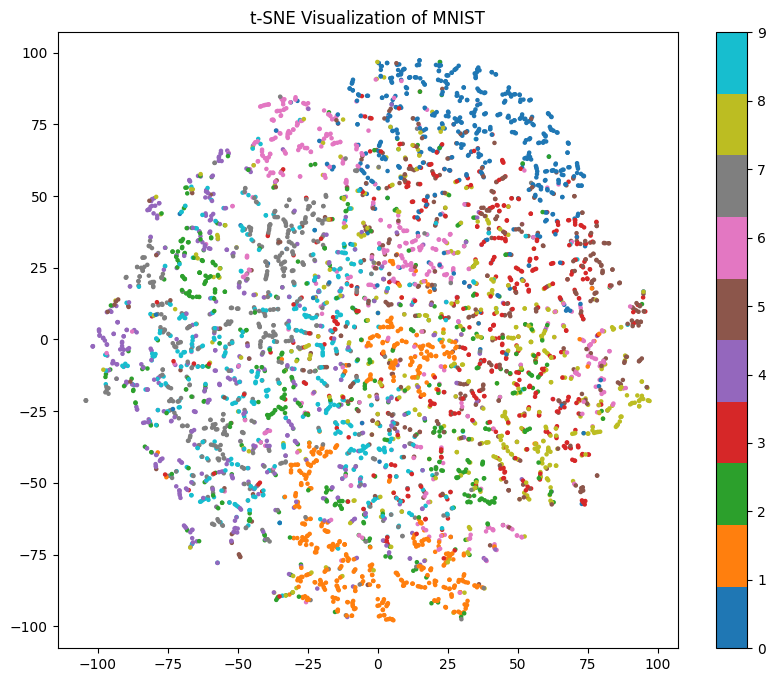

In [11]:
# t-SNE with PCA 
pca_var_score = data_torch.numpy() @ factor_layer.V.detach().numpy()
torch.manual_seed(123456)
pca_var_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(pca_var_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(pca_var_embedding[:, 0], pca_var_embedding[:, 1], c=mnist_dataset.targets[subset_indices], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## ICA

ICA is a matrix factorization that sets different criteria from PCA; ICA maximizes the independence between score vectors rather than maximizing the variance of scores as follows;

$$
X' = AS
$$

, where $X$ is the whitened data matrix ($n \times k$),  $A$ is the loading matrix ($n \times k$), and $S$ is the score matrix ($k \times m$), which means $k$-set of score vectors. To realize bthe independence between score vectors. Here we introduce some ICA methods such as Kurtosis, Negentropy and DDICA.

### Whitening data matrix

ICA first performs PCA to the input data and then performs "whitening" step to make the distribution of the data spherical by dividing each score by the variance.
Here, we use the `pca_score` that we have already calculated.
Since ICA of `PyTorchDecomp` does not have the functionality of dimensionality compression, this also serves as dimensionality compression.

In [12]:
white_score_np = pca_score / np.linalg.norm(pca_score, axis=0)
white_score_torch = torch.tensor(white_score_np)

## ICA (Kurtosis-based)

In [13]:
# Instantiation of RotationLayer
rotation_layer = td.RotationLayer(white_score_torch)

# Loss Function (Kurtosis)
loss_kurtosis = td.KurtosisICALayer()

# Setting Optimzer
optimizer = torch.optim.SGD(rotation_layer.parameters(), lr=0.05)

# Iteration
loss_array = []
epochs = 100
for epoch in range(epochs):
    outputs_kurtosis = rotation_layer(white_score_torch)    
    loss = loss_kurtosis(outputs_kurtosis)
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

The calculations appear to be well converged.

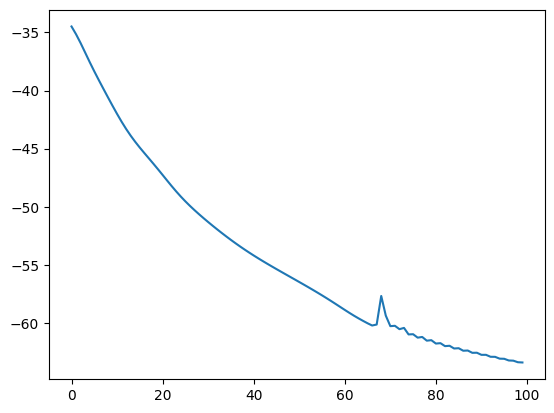

In [14]:
plt.plot(loss_array)
plt.show()

### Pattern Check

The scores ($S$) seem to be able to extract patterns along with the differences in the MNIST numbers.

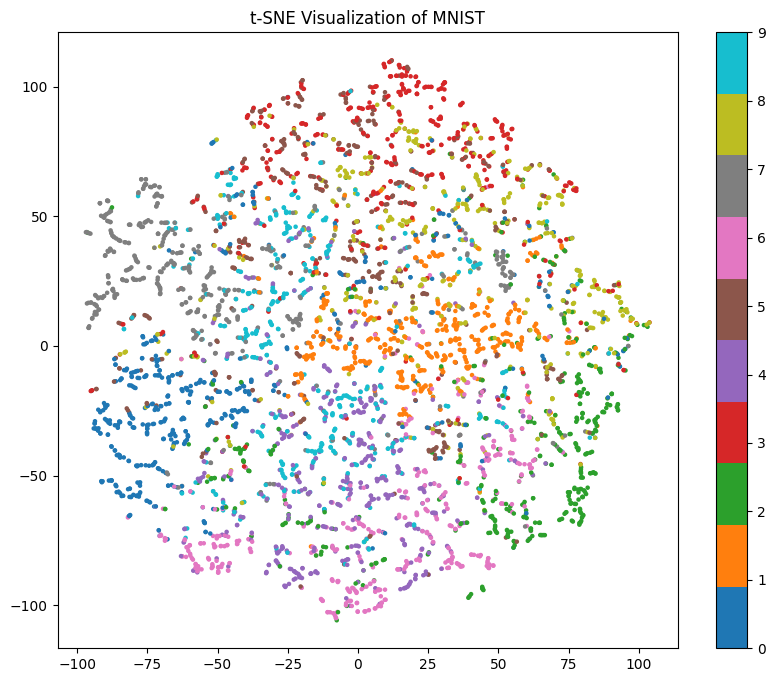

In [15]:
# t-SNE with ICA
ica_kurtosis_score = white_score_np @ rotation_layer.mixing_matrix.detach().numpy()
torch.manual_seed(123456)
ica_kurtosis_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(ica_kurtosis_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(ica_kurtosis_embedding[:, 0], ica_kurtosis_embedding[:, 1], c=mnist_dataset.targets[subset_indices], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## ICA (Negentropy-based)

In [16]:
# Instantiation of RotationLayer
rotation_layer = td.RotationLayer(white_score_torch)

# Loss Function (Negentropy)
loss_negentropy = td.NegentropyICALayer()

# Setting Optimizer
optimizer = torch.optim.SGD(rotation_layer.parameters(), lr=0.05)

# Iteration
loss_array = []
epochs = 100
for epoch in range(epochs):
    outputs_negentropy = rotation_layer(white_score_torch)    
    loss = loss_negentropy(outputs_negentropy)
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

The calculations appear to be well converged.

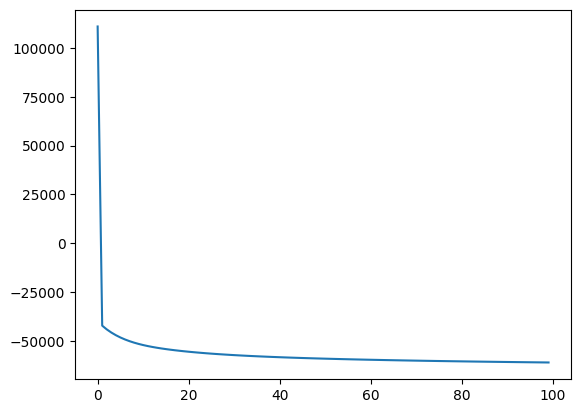

In [17]:
plt.plot(loss_array)
plt.show()

### Pattern Check

The scores ($S$) seem to be able to extract patterns along with the differences in the MNIST numbers.

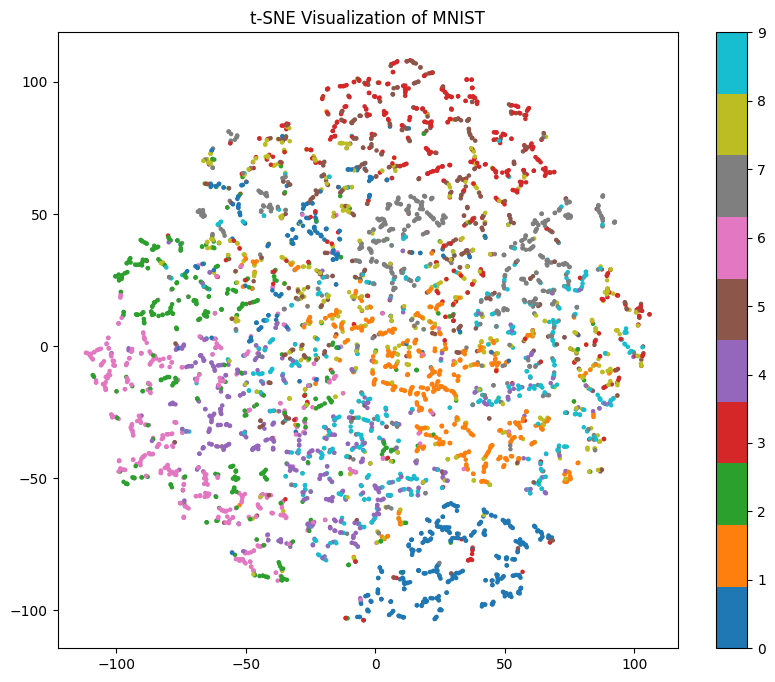

In [18]:
# t-SNE with ICA
ica_negentropy_score = white_score_np @ rotation_layer.mixing_matrix.detach().numpy()
torch.manual_seed(123456)
ica_negentropy_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(ica_negentropy_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(ica_negentropy_embedding[:, 0], ica_negentropy_embedding[:, 1], c=mnist_dataset.targets[subset_indices], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## ICA (DDICA)

In [19]:
# Instantiation of DDICALayer
torch.manual_seed(123543)
ddica_layer = td.DDICALayer(white_score_torch[1:500,:], sigma=0.01, alpha=0.75)

# Setting Optimizer
optimizer = torch.optim.SGD(ddica_layer.parameters(), lr=5e-6)

# Iteration
loss_array = []
epochs = 30
for epoch in range(epochs):
    loss = ddica_layer(white_score_torch[1:500,:])
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

The calculations appear to be well converged.

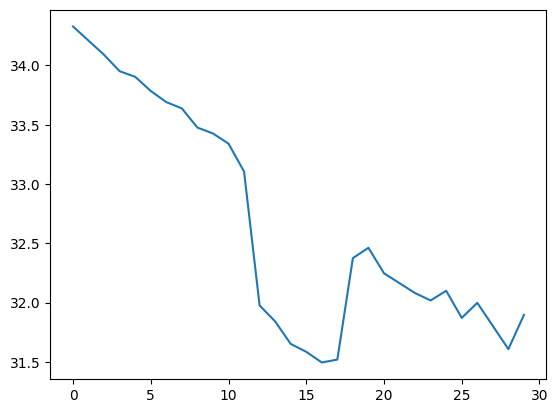

In [20]:
plt.plot(loss_array)
plt.show()

### Pattern Check

The scores ($S$) seem to be able to extract patterns along with the differences in the MNIST numbers.

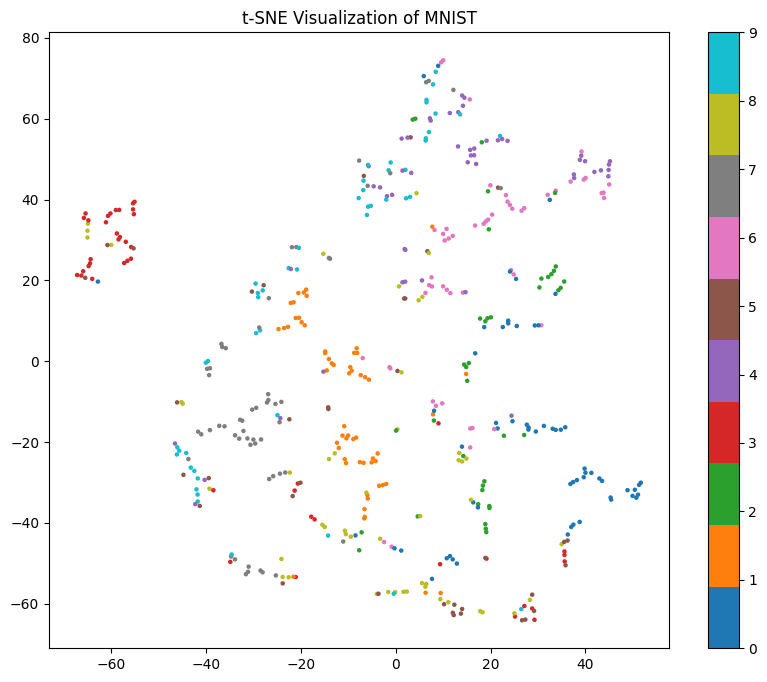

In [21]:
# t-SNE with DDICA
ddica_score = white_score_np[1:500,:] @ ddica_layer.mixing_matrix.detach().numpy()
torch.manual_seed(123456)
ddica_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(ddica_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(ddica_embedding[:, 0], ddica_embedding[:, 1], c=mnist_dataset.targets[subset_indices[1:500]], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## NMF (Beta-divergence)

NMF is somewhat unique matrix factorization; the input data matrix $X$ is assumed to be non-negative, and then it is approximated by the matrix product $WH$ as follows:

$$
X = WH
$$

, where $X$ is the non-negative data matrix ($n \times m$), $W$ ($n \times k$) and $H$ ($k \times m$) are both non-negative matrices.

To realize this decomposition, we used a NMF formulation based on Beta-divergence between $X$ and $WH$.


In [22]:
# Instantiation of NMFLayer
nmf_layer = td.NMFLayer(data_torch, 10)

# Iteration
loss_array = []
epochs = 100
for epoch in range(epochs):
    # Initialize Gradient
    nmf_layer.zero_grad()
    # Forward
    loss, WH, pos, neg, pos_w, neg_w, pos_h, neg_h = nmf_layer(data_torch)
    # Loss
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    # Multiplicative Update (MU) rule
    with torch.no_grad():
        # Gradients
        grad_pos, grad_neg, grad_pos_w, grad_neg_w, grad_pos_h, grad_neg_h = td.gradNMF(
            WH, pos, neg, pos_w, neg_w, pos_h, neg_h, nmf_layer)
        # Update
        W, H = td.updateNMF(grad_pos, grad_neg, grad_pos_w, grad_neg_w, grad_pos_h, grad_neg_h, nmf_layer)
        nmf_layer.W.data = W
        nmf_layer.H.data = H

### Convergence Check

The calculations appear to be well converged.

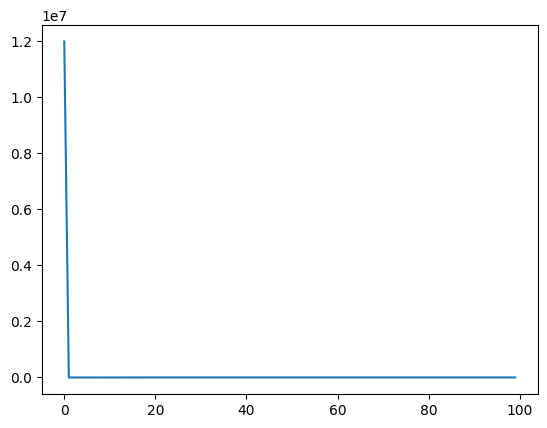

In [23]:
plt.plot(loss_array)
plt.show()

### Pattern Check

The scores ($W$) seem to be able to extract patterns along with the differences in the MNIST numbers.

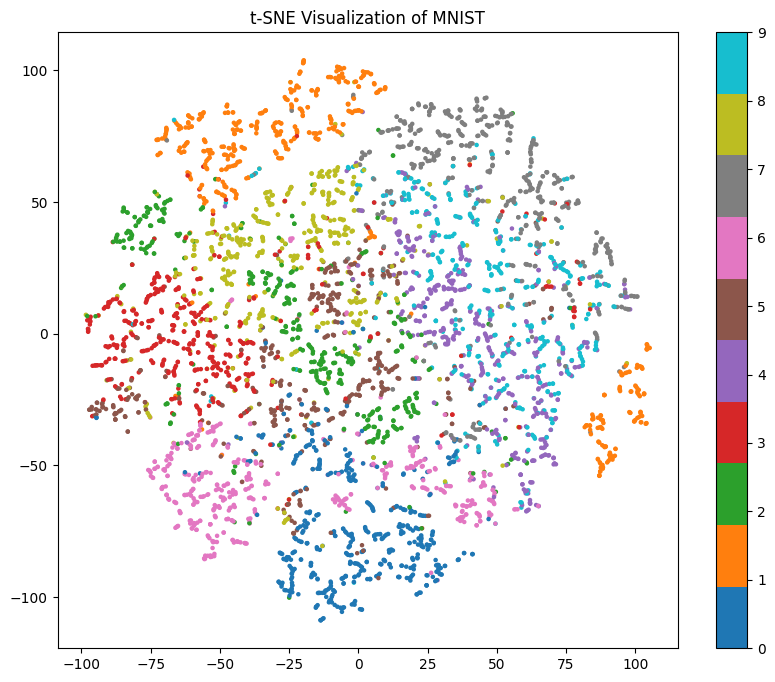

In [24]:
# t-SNE with NMF
nmf_score = nmf_layer.W.data.detach().numpy()
torch.manual_seed(123456)
nmf_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(nmf_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(nmf_embedding[:, 0], nmf_embedding[:, 1], c=mnist_dataset.targets[subset_indices], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## References

- **Principal Component Analysis (PCA)**
  - R. Arora, A. Cotter, K. Livescu and N. Srebro, Stochastic optimization for PCA and PLS, 2012 50th Annual Allerton Conference on Communication, Control, and Computing, 2012, 861-868. 2012
- **Independent Component Analysis (ICA)**
  - Hybarinen, A. and Oja, E. Independent component analysis: algorithms and applications, Neural Networks, 13, 411-430. 2000
- **Deep Deterministic ICA (DDICA)**
  - H. Li, S. Yu and J. C. Príncipe, Deep Deterministic Independent Component Analysis for Hyperspectral Unmixing, 2022 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), 3878-3882, 2022
- **Non-negative Matrix Factorization (NMF)**
  - Kimura, K. A Study on Efficient Algorithms for Nonnegative Matrix/Tensor Factorization, Ph.D. Thesis, 2017
  - **Exponent term depending on Beta parameter**
    - Nakano, M. et al., Convergence-guaranteed multiplicative algorithms for nonnegative matrix factorization with Beta-divergence. IEEE MLSP, 283-288, 2010
  - **Beta-divergence NMF and Backpropagation**
    - https://yoyololicon.github.io/posts/2021/02/torchnmf-algorithm/